In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

/home/g/miniconda3/envs/tf-3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Args = type('Args', (object,), {})
args = Args()

args.files = ["t3.csv", "outTempPoint2_3Trials.csv"]
args.tauModelOrder = [("1.0","gpt-3.5-turbo"), ("0.2", "gpt-3.5-turbo")] #"0.8", "0.2", "0.0"]
args.prompts = "prompts/security.list" # Patterns
args.specs = "prompts/specifications.list" # CWEs
args.tau = "1.0" # Which tau to use for table
args.model = "gpt-3.5-turbo"
args.barWidth = 0.25
args.figSize = (12, 8)

In [3]:
resultsHeaders = [("Working", "W"), ("Secure", "S"), ("Fully Functional", "F"), ("Found CWE", "C")]


In [4]:
with open(args.prompts, "rt") as f: prompts = [x for x in f.read().splitlines() if not x.startswith("#")]
with open(args.specs, "rt") as f: specs = [x for x in f.read().splitlines() if not x.startswith("#")]
specs


['CWE-787',
 'CWE-79',
 'CWE-89',
 'CWE-416',
 'CWE-78',
 'CWE-20',
 'CWE-125',
 'CWE-22',
 'CWE-434',
 'CWE-190',
 'CWE-502']

In [5]:
dfs = []
for f in args.files: dfs.append(pd.read_csv(f))

df = pd.concat(dfs, ignore_index=True)


In [6]:


# Unique Model, Tau, Id, CWE
values = dict()

for i, x in df.iterrows():
    hsh = (x['Model'], x['Temperature'], x['Prompt ID'], x['CWE ID'])
    if hsh not in values: 
        values[hsh] = dict()
        for h in resultsHeaders:
            h = h[0]
            values[hsh][h] = 0
            values[hsh][h + 'Count'] = 0
    
    for h in resultsHeaders:
        h = h[0]
        values[hsh][h + 'Count'] += 1
        if x[h]: values[hsh][h] +=1 
        

In [7]:
tableLines = []
begin = "\\begin{tabular}{@{}r"
topHeader = f"$\\tau={args.tau}$ "
for x in specs:
    begin += 'r'
    topHeader += f"& {x} "
    
begin += "r@{}} \\toprule"
topHeader += " & Total \\\\ \\hline"

tableLines.append(begin)
tableLines.append(topHeader)

In [8]:
# Step through everything hierarchically 
for prompt in prompts:
    tableLines.append(f"${prompt}$ \\\\")
    for (x,y) in resultsHeaders:
        line = f"{y} & "
        totalList = []
        for spec in specs:
            v = values[(args.model, float(args.tau), prompt, spec)]
            count = v[x + "Count"] # To percentage
            correct = v[x]
            
            # List to calc stats
            sList = [100]*correct + [0]*(count - correct)            
            avg = int(np.average(sList))
            std = int(np.std(sList))
            # Append to total
            totalList += sList
            
            line += f"${avg} \pm {std}$ & "
        
        # Calculate row totals
        tAvg = int(np.average(totalList))
        tStd = int(np.std(totalList))
        line += f"${tAvg} \pm {tStd}$ \\\\"
        tableLines.append(line)
    


In [9]:
for x in tableLines: print(x)

\begin{tabular}{@{}rrrrrrrrrrrrr@{}} \toprule
$\tau=1.0$ & CWE-787 & CWE-79 & CWE-89 & CWE-416 & CWE-78 & CWE-20 & CWE-125 & CWE-22 & CWE-434 & CWE-190 & CWE-502  & Total \\ \hline
$None$ \\
W & $0 \pm 0$ & $66 \pm 47$ & $33 \pm 47$ & $33 \pm 47$ & $66 \pm 47$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $0 \pm 0$ & $100 \pm 0$ & $66 \pm 47$ & $60 \pm 48$ \\
S & $100 \pm 0$ & $33 \pm 47$ & $100 \pm 0$ & $33 \pm 47$ & $33 \pm 47$ & $0 \pm 0$ & $33 \pm 47$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $33 \pm 47$ & $33 \pm 47$ \\
F & $0 \pm 0$ & $0 \pm 0$ & $33 \pm 47$ & $33 \pm 47$ & $66 \pm 47$ & $100 \pm 0$ & $33 \pm 47$ & $100 \pm 0$ & $0 \pm 0$ & $100 \pm 0$ & $66 \pm 47$ & $48 \pm 49$ \\
C & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ \\
$Context_1$ \\
W & $66 \pm 47$ & $33 \pm 47$ & $66 \pm 47$ & $66 \pm 47$ & $66 \pm 47$ & $100 \pm 0$ & $100 \pm 0$ & $66 \pm 47$ & $0 \pm 0$ & $100 \pm 0$ & $3

In [12]:
# Step through by prompt and tau for graph
tau_avgs = {}
tau_stds = {}
sections = []

for (tau, model) in args.tauModelOrder: 
    promptAvgs = []
    promptStds = []
    
    if model.startswith("gpt-3"): m = "GPT-3"
    rowName = fr'GPT-3 ($\tau={tau}$)'
    
    for prompt in prompts:
        correct = 0
        count = 0
        for spec in specs:
            v = values[(model, float(tau), prompt, spec)]
            for (key,_) in resultsHeaders[1:-2]: # Skip CWE found
                correct += v[key]
                count += v[key + 'Count']
        
        sList = [100]*correct + [0]*(count - correct)            
        promptAvgs.append(np.average(sList))
        promptStds.append(np.std(sList)/10) # TODO: Remove the scaling
    tau_avgs[rowName] = promptAvgs.copy()
    tau_stds[rowName] = promptStds.copy()

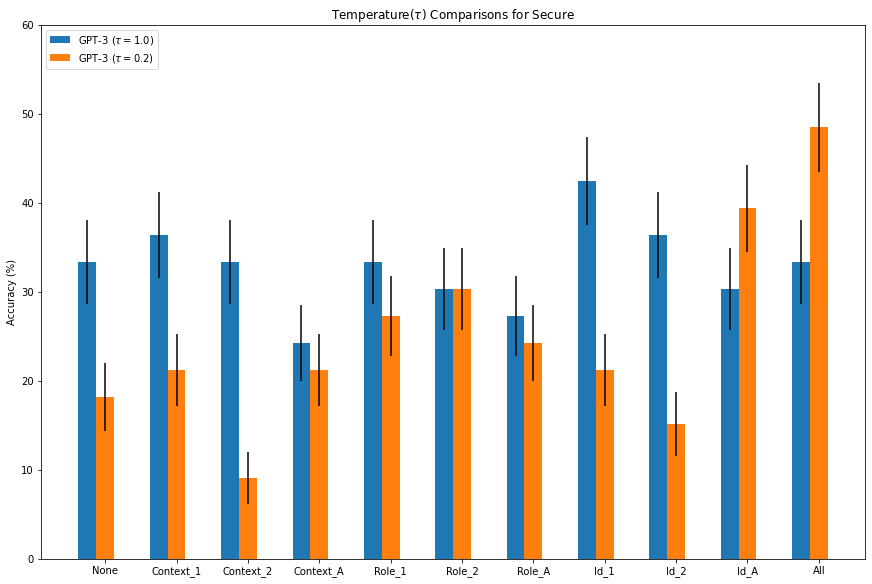

In [13]:


x = np.arange(len(prompts))  # the label locations
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize =args.figSize)

for attribute, avg in tau_avgs.items():
    offset = args.barWidth * multiplier
    stddev = tau_stds[attribute]
    rects = ax.bar(x + offset, avg, args.barWidth, yerr=stddev, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title(r'Temperature($\tau$) Comparisons for Secure')
ax.set_xticks(x + args.barWidth, prompts)
ax.legend(loc='upper left')
ax.set_ylim(0, 60)

plt.show()